### **Load Libraries & Data Paths**

In [ ]:
# Libraries
import os
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


# Dataset paths
train_dir = "/content/drive/MyDrive/NIH_processed/train"
test_dir  = "/content/drive/MyDrive/NIH_processed/test"
BATCH_SIZE = 32
EPOCHS = 30
INPUT_SIZE = 299
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Check class distribution quickly
def check_class_imbalance(directory):
    print(f"Checking class distribution in: {directory}")
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {class_name}: {count} images")
    print()

check_class_imbalance(train_dir)
check_class_imbalance(test_dir)


Checking class distribution in: /content/drive/MyDrive/NIH_processed/train
  normal: 4069 images
  pneumonia: 1251 images

Checking class distribution in: /content/drive/MyDrive/NIH_processed/test
  normal: 1272 images
  pneumonia: 512 images



In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transform = val_transform

In [ ]:

# Create full ImageFolder for train_dir and create stratified train/val split
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_targets = np.array([s[1] for s in full_train_dataset.samples])  # labels

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(train_targets)), train_targets))

train_dataset = Subset(full_train_dataset, train_idx)

# use same underlying ImageFolder but with val_transform
full_train_dataset_val = datasets.ImageFolder(train_dir, transform=val_transform)
val_dataset = Subset(full_train_dataset_val, val_idx)

# Test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)


# Dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    'val':   DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False),
    'test':  DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val':   len(val_dataset),
    'test':  len(test_dataset)
}

class_names = full_train_dataset.classes

#### **Build Model**

In [ ]:
# Model setup (InceptionV3)
model = models.inception_v3(weights='DEFAULT', aux_logits=True)
for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

#### **Train Model**

In [ ]:
# Training loop
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Calculate class weights
class_counts = np.bincount([s[1] for s in full_train_dataset.samples])
total_samples = sum(class_counts)
num_classes = len(class_counts)
class_weights = total_samples / (num_classes * class_counts)
class_weights = torch.FloatTensor(class_weights).to(DEVICE)

# Update criterion with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    epoch_start = time.time()

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                # InceptionV3 with aux_logits=True returns a named tuple
                outputs = model(inputs)
                if phase == 'train' and isinstance(outputs, torch.utils.data.dataloader.DataLoader):
                    # Access main output when training
                    outputs = outputs.logits
                elif not isinstance(outputs, torch.Tensor):
                    # Access main output for evaluation if not a tensor
                     outputs = outputs.logits


                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f" {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc.item())


        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            best_model_path = os.path.join(os.path.dirname(train_dir), "inceptionv3_best_model_nh.pth")
            torch.save({'model_state_dict': best_model_wts,
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'train_accs': train_accs,
                        'val_accs': val_accs},
                       best_model_path)


    scheduler.step()
    epoch_time = (time.time() - epoch_start) / 60.0
    print(f" Epoch time: {epoch_time:.2f} minutes\n")

print(f"Best val Acc: {best_acc:.4f}")

# save history
history_path = os.path.join(os.path.dirname(train_dir), "history_nh.pth")
torch.save({'train_losses': train_losses, 'val_losses': val_losses,
            'train_accs': train_accs, 'val_accs': val_accs}, history_path)


# load best weights
model.load_state_dict(best_model_wts)

Epoch 1/30
 train Loss: 0.6809 Acc: 0.6144
 val Loss: 0.6622 Acc: 0.6466
 Epoch time: 58.64 minutes

Epoch 2/30
 train Loss: 0.6549 Acc: 0.6584
 val Loss: 0.6407 Acc: 0.6494
 Epoch time: 8.70 minutes

Epoch 3/30
 train Loss: 0.6318 Acc: 0.6739
 val Loss: 0.6286 Acc: 0.6513
 Epoch time: 8.75 minutes

Epoch 4/30
 train Loss: 0.6237 Acc: 0.6696
 val Loss: 0.6214 Acc: 0.6852
 Epoch time: 8.67 minutes

Epoch 5/30
 train Loss: 0.6259 Acc: 0.6767
 val Loss: 0.6265 Acc: 0.7312
 Epoch time: 8.64 minutes

Epoch 6/30
 train Loss: 0.6132 Acc: 0.6894
 val Loss: 0.6163 Acc: 0.6617
 Epoch time: 8.65 minutes

Epoch 7/30
 train Loss: 0.6023 Acc: 0.6938
 val Loss: 0.6135 Acc: 0.6880
 Epoch time: 8.71 minutes

Epoch 8/30
 train Loss: 0.6043 Acc: 0.6896
 val Loss: 0.6130 Acc: 0.6983
 Epoch time: 8.79 minutes

Epoch 9/30
 train Loss: 0.6057 Acc: 0.6852
 val Loss: 0.6337 Acc: 0.7397
 Epoch time: 8.78 minutes

Epoch 10/30
 train Loss: 0.5998 Acc: 0.7014
 val Loss: 0.6143 Acc: 0.7105
 Epoch time: 8.74 minutes

<All keys matched successfully>

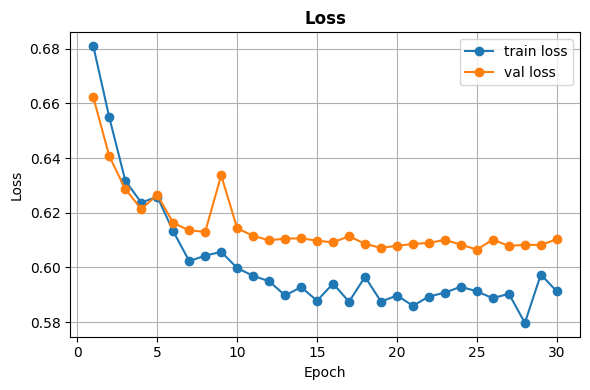

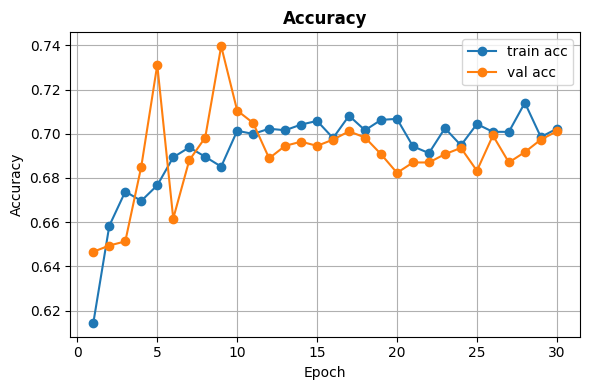

In [ ]:

## Loss curves
epochs = list(range(1, len(train_losses) + 1))

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, marker='o', label='train loss')
plt.plot(epochs, val_losses, marker='o', label='val loss')
plt.title('Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_accs, marker='o', label='train acc')
plt.plot(epochs, val_accs, marker='o', label='val acc')
plt.title('Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Loss Curves from Saved files**

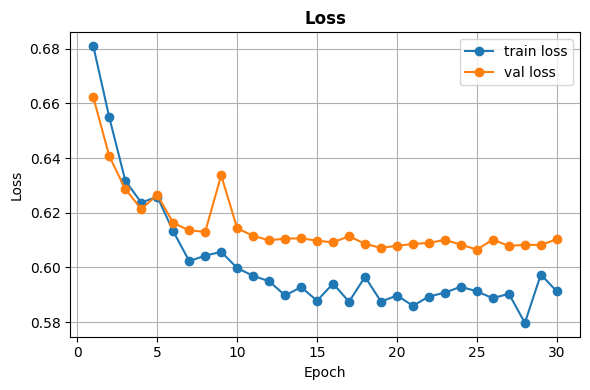

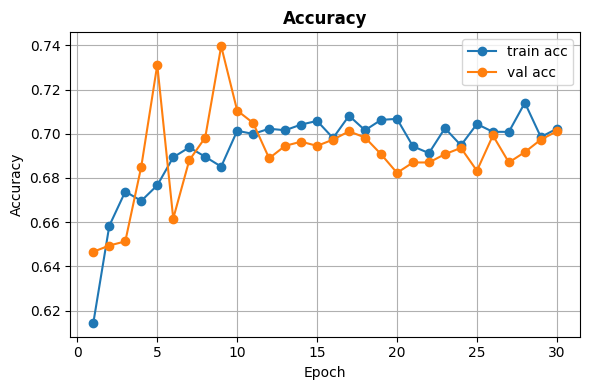

In [ ]:
import matplotlib.pyplot as plt
import torch
import os

# Define the path to the saved history
history_path = os.path.join(os.path.dirname(train_dir), "history_nh.pth")

# Load the history
history = torch.load(history_path)

train_loss = history['train_losses']
val_loss = history['val_losses']
train_acc = history['train_accs']
val_acc = history['val_accs']

epochs = list(range(1, len(train_loss) + 1))

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, marker='o', label='train loss')
plt.plot(epochs, val_loss, marker='o', label='val loss')
plt.title('Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, marker='o', label='train acc')
plt.plot(epochs, val_acc, marker='o', label='val acc')
plt.title('Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Evaluation**

Total Correct: 1315
Total Test Images: 1784
Test Accuracy: 0.7371
Test Loss: 0.5308

Classification Report:
              precision    recall  f1-score   support

      normal     0.8012    0.8396    0.8200      1272
   pneumonia     0.5477    0.4824    0.5130       512

    accuracy                         0.7371      1784
   macro avg     0.6744    0.6610    0.6665      1784
weighted avg     0.7284    0.7371    0.7319      1784



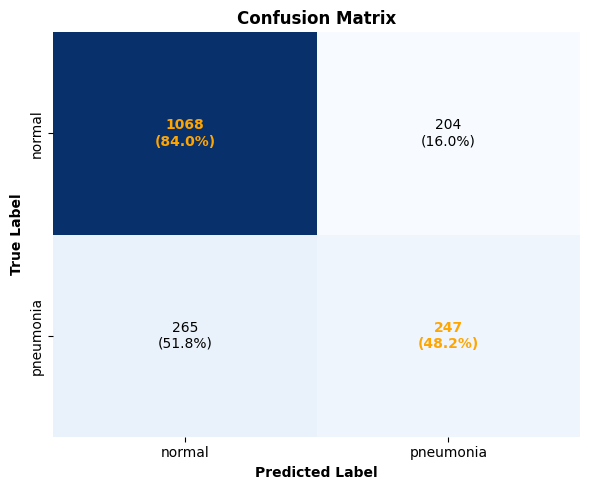


AUROC: 0.7519


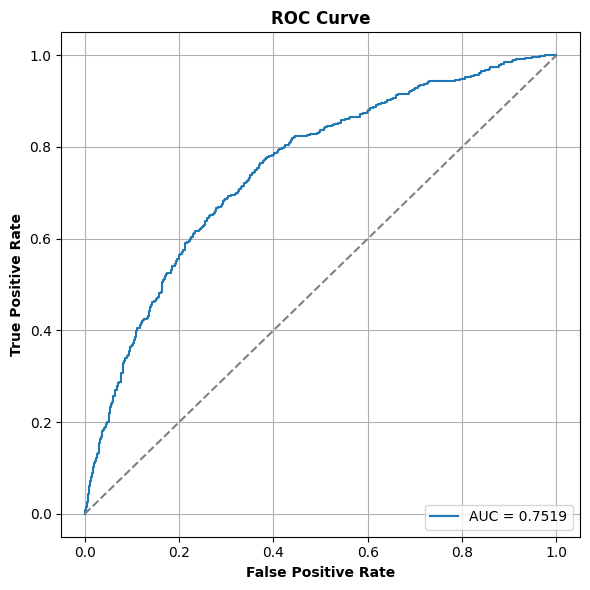

In [ ]:
# -----------------------------------------------------------------------------
# Test / Evaluation: compute test loss, accuracy, classification report, AUROC, confusion matrix
# -----------------------------------------------------------------------------
model.eval()
all_labels = []
all_probs = []
all_preds = []
test_running_loss = 0.0
test_running_corrects = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        batch_size = inputs.size(0)
        test_running_loss += loss.item() * batch_size
        test_running_corrects += torch.sum(preds == labels.data).item()
        test_total += batch_size

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)
        all_preds.extend(preds.cpu().numpy())

avg_test_loss = test_running_loss / test_total
test_acc = test_running_corrects / test_total

print(f"Total Correct: {int(test_running_corrects)}")
print(f"Total Test Images: {test_total}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {avg_test_loss:.4f}")

# classification report (4 significant figures)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# confusion matrix (counts + row-wise %), bold diagonal
cm = confusion_matrix(all_labels, all_preds)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}\n({pct:.1f}%)",
                ha='center', va='center',
                color='orange' if i == j else 'black',
                fontweight='bold' if i == j else 'normal')
plt.title("Confusion Matrix", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

# AUROC and ROC curve (4 significant figures)
auc_score = roc_auc_score(all_labels, all_probs)
print(f"\nAUROC: {auc_score:.4f}")
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Total Correct: 1315
Total Test Images: 1784
Test Accuracy : 0.7371
Test Loss: 0.5308

Classification Report:
              precision    recall  f1-score   support

      normal     0.8012    0.8396    0.8200      1272
   pneumonia     0.5477    0.4824    0.5130       512

    accuracy                         0.7371      1784
   macro avg     0.6744    0.6610    0.6665      1784
weighted avg     0.7284    0.7371    0.7319      1784



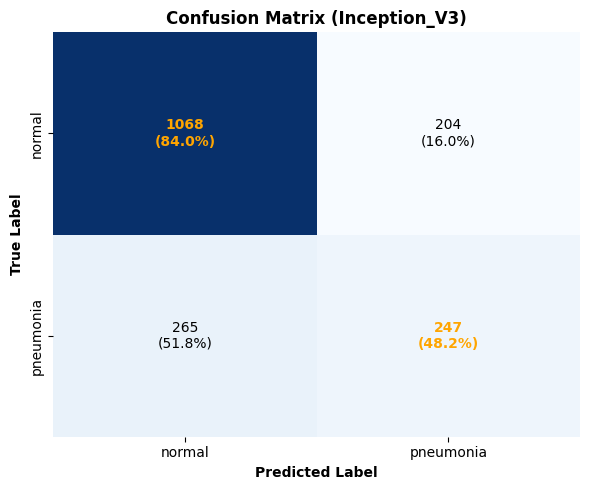


AUROC: 0.7519


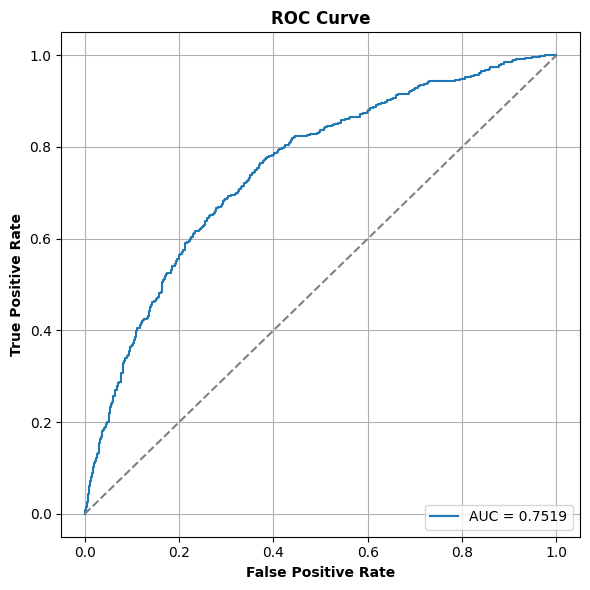

In [ ]:
# Load best model and perform evaluation
# Define the path to the saved best model
best_model_path = os.path.join(os.path.dirname(train_dir), "inceptionv3_best_model_nh.pth")

# Load the saved model state dictionary
# Ensure the model architecture is defined before loading the state dict
model = models.inception_v3(weights='DEFAULT', aux_logits=True)
for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)
model = model.to(DEVICE)


checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
all_labels = []
all_probs = []
all_preds_threshold = []  # Predictions based on threshold
test_running_loss = 0.0
test_running_corrects = 0
test_total = 0

# Define the threshold for classification
classification_threshold = 0.5

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        _, preds_max = torch.max(outputs, 1) # Keep this to compare if needed, but not used for metrics

        loss = criterion(outputs, labels)
        batch_size = inputs.size(0)
        test_running_loss += loss.item() * batch_size
        test_total += batch_size

        # Classify based on the defined threshold
        preds_threshold = (probs > classification_threshold).astype(int)
        test_running_corrects += np.sum(preds_threshold == labels.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)
        all_preds_threshold.extend(preds_threshold) # Use threshold predictions for metrics

avg_test_loss = test_running_loss / test_total
test_acc = test_running_corrects / test_total

print(f"Total Correct: {int(test_running_corrects)}")
print(f"Total Test Images: {test_total}")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test Loss: {avg_test_loss:.4f}")

# classification report (4 significant figures)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds_threshold, target_names=class_names, digits=4))

# confusion matrix (counts + row-wise %), bold diagonal
cm = confusion_matrix(all_labels, all_preds_threshold)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}\n({pct:.1f}%)",
                ha='center', va='center',
                color='orange' if i == j else 'black',
                fontweight='bold' if i == j else 'normal')
plt.title("Confusion Matrix (Inception_V3)", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

# AUROC and ROC curve (4 significant figures)
auc_score = roc_auc_score(all_labels, all_probs) # AUROC is calculated using probabilities, not thresholded predictions
print(f"\nAUROC: {auc_score:.4f}")
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Testing with Optimal Threshold (Optional)**

Optimal Threshold (maximizing F1 for pneumonia): 0.3232
Total Test Images: 1784
Test Accuracy: 0.6626
Test Loss: 0.5308

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      normal     0.8706    0.6187    0.7233      1272
   pneumonia     0.4489    0.7715    0.5675       512

    accuracy                         0.6626      1784
   macro avg     0.6597    0.6951    0.6454      1784
weighted avg     0.7495    0.6626    0.6786      1784



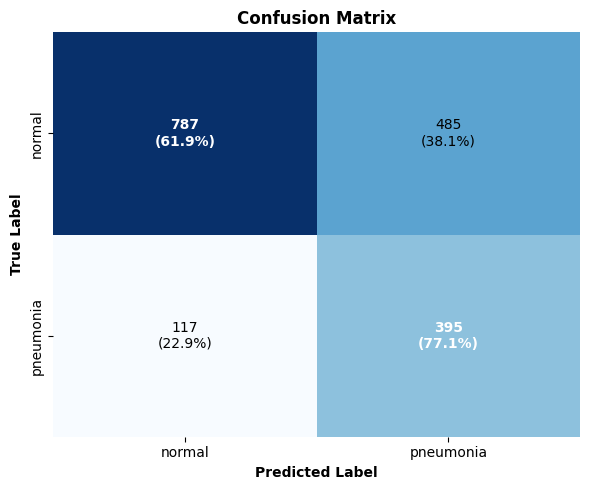


AUROC: 0.7519


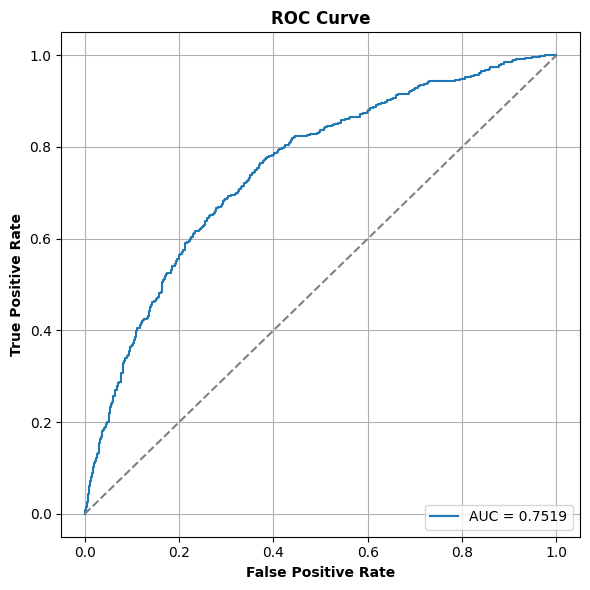

In [ ]:
# Load optimal model weights, find optimal threshold, and perform evaluation
from sklearn.metrics import f1_score # Import f1_score

# Define the path to the saved best model
best_model_path = os.path.join(os.path.dirname(train_dir), "inceptionv3_best_model_nh.pth")

# Load the saved model state dictionary
model = models.inception_v3(weights='DEFAULT', aux_logits=True) # Using default weights and aux_logits=True as in the successful training run
for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)
model = model.to(DEVICE)


checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
all_labels = []
all_probs = []
test_running_loss = 0.0
test_total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()

        loss = criterion(outputs, labels)
        batch_size = inputs.size(0)
        test_running_loss += loss.item() * batch_size
        test_total += batch_size

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)

avg_test_loss = test_running_loss / test_total
# Accuracy and other metrics will be calculated after finding the optimal threshold

# Find optimal threshold (maximizing F1-score for the positive class - pneumonia)
best_f1 = 0
optimal_threshold = 0.5  # Default threshold

# Evaluate F1-score for a range of thresholds
for threshold in np.linspace(0, 1, 100):
    preds_threshold = (np.array(all_probs) > threshold).astype(int)
    f1 = f1_score(all_labels, preds_threshold, pos_label=1) # pos_label=1 for pneumonia
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = threshold

print(f"Optimal Threshold (maximizing F1 for pneumonia): {optimal_threshold:.4f}")

# Evaluate using the optimal threshold
all_preds_optimal_threshold = (np.array(all_probs) > optimal_threshold).astype(int)
test_running_corrects_optimal = np.sum(all_preds_optimal_threshold == np.array(all_labels))
test_acc_optimal = test_running_corrects_optimal / test_total

print(f"Total Test Images: {test_total}")
print(f"Test Accuracy: {test_acc_optimal:.4f}")
print(f"Test Loss: {avg_test_loss:.4f}") # Loss is still calculated based on raw outputs

# classification report (4 significant figures)
print("\nClassification Report (Optimal Threshold):")
print(classification_report(all_labels, all_preds_optimal_threshold, target_names=class_names, digits=4))

# confusion matrix (counts + row-wise %), bold diagonal
cm = confusion_matrix(all_labels, all_preds_optimal_threshold)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}\n({pct:.1f}%)",
                ha='center', va='center',
                color='white' if i == j else 'black',
                fontweight='bold' if i == j else 'normal')
plt.title(f"Confusion Matrix", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

# AUROC and ROC curve (4 significant figures)
auc_score = roc_auc_score(all_labels, all_probs) # AUROC is calculated using probabilities
print(f"\nAUROC: {auc_score:.4f}")
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Model Parameter Count**

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
untrainable_params = total_params - trainable_params

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Untrainable parameters: {untrainable_params}")

Total parameters: 25374794
Trainable parameters: 262530
Untrainable parameters: 25112264


In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

summary(model, input_size=(3, INPUT_SIZE, INPUT_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [ ]:
import os

# Define the path to the saved best model
train_dir = "/content/drive/MyDrive/NIH_processed/train" # Define train_dir
best_model_path = os.path.join(os.path.dirname(train_dir), "inceptionv3_best_model_nh.pth")

# Get the file size in bytes
file_size_bytes = os.path.getsize(best_model_path)

# Convert bytes to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)

print(f"Model Name: {os.path.basename(best_model_path)}")
print(f"Model Size: {file_size_mb:.2f} MB")

Model Name: inceptionv3_best_model_nh.pth
Model Size: 97.13 MB
